# Aitchison metric sensitivity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform, euclidean, braycurtis, jensenshannon
from scipy.stats.mstats import gmean

from skbio.stats.composition import clr

# Functions

In [2]:
def aitchison(x, y, pseudo=1, subset=True):
    """
    Compute the Aitchison distance on vectors x and y after adding a pseudocount to allow for log transformation.
    If subset = True, subset x and y to entries that are present in either or both
    """
    x = x.copy()
    y = y.copy()
    
    if subset:
        union = (x > 0) | (y > 0)
        x = x[union]
        y = y[union]
    
    # Add pseudo count
    x += pseudo
    y += pseudo
    
    # Perform clr transform
    x_clr = clr(x)
    y_clr = clr(y)
    return euclidean(x_clr, y_clr)

# Test sensitivity of divergence to richness

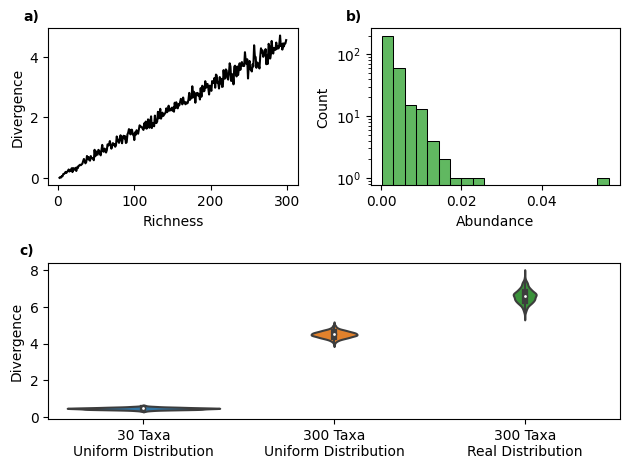

In [3]:
"Load real data"
# Load
real_sample = pd.read_csv('data/env_complexity_asv_publication.csv', index_col=0)['HF2P15-initial-powersoil_S385-C2-R2']
depth = real_sample.sum()
richness = real_sample.gt(0).sum()

# Calculate priors
real_prior = real_sample[real_sample.gt(0)].div(depth).sort_values(ascending=False)

"How does Aitchison change with increasing richness of uniformly distributed data"
r = range(2, richness)
aitchison_range = []

for k in r:
    # Sample reads and place into empty vectors to keep 
    ## vector size constant for each k
    sampling = np.random.multinomial(depth, np.ones(k)/k, 2)
    abundance = np.zeros((2, richness))
    abundance[:, :k] = sampling
    
    # Compute distances
    aitch = aitchison(*abundance)
    aitchison_range.append(aitch)

"How is divergence distributed for uniformly vs. unevenly distributed data"
n = 50
np.random.seed(123)
sampled_data = np.random.multinomial(depth, real_prior, n)
sampled_uniform = np.random.multinomial(depth, np.ones(richness) / richness, n)
lower_richness = int(richness / 10)
sampled_uniform_low_diversity = np.random.multinomial(depth, np.ones(lower_richness) / lower_richness, n)

divergences = {metric: pdist(d, aitchison) for metric, d in zip([f'{lower_richness} Taxa\nUniform Distribution', f'{richness} Taxa\nUniform Distribution', f'{richness} Taxa\nReal Distribution'], 
                                                                [sampled_uniform_low_diversity, sampled_uniform, sampled_data])}
div_df = pd.DataFrame(divergences)

"Plot"
mosaic = [['div_div', 'counts'], ['dist', 'dist']]

fig, axs = plt.subplot_mosaic(mosaic)

# Richness vs. Aitchison
axs['div_div'].plot(r, aitchison_range, color='k')
axs['div_div'].set_xlabel('Richness')
axs['div_div'].set_ylabel('Divergence')
axs['div_div'].text(-.1, 1.05, 'a)', transform=axs['div_div'].transAxes, fontweight='bold')

# Distribution of abundance in real sample
sns.histplot(real_prior, bins=20, ax=axs['counts'], color=sns.color_palette()[2])
axs['counts'].set_xlabel('Abundance')
# axs['counts'].set_ylabel('')
axs['counts'].set_yscale('log')
axs['counts'].text(-.1, 1.05, 'b)', transform=axs['counts'].transAxes, fontweight='bold')

# Distribution of divergences from simulations
sns.violinplot(div_df, ax=axs['dist'])
axs['dist'].set_ylabel('Divergence')
axs['dist'].text(-.05, 1.05, 'c)', transform=axs['dist'].transAxes, fontweight='bold')

plt.tight_layout()
# plt.savefig('publication_figures/supplement_diversity_divergence.png', bbox_inches='tight', dpi=300)
plt.show()

In [11]:
with pd.ExcelWriter('publication_figures_source_data/Supplementary_FigureS1.xlsx') as fh:
    pd.Series(aitchison_range, r).rename_axis('Richness').rename('Divergence').to_excel(fh, 'S1a')
    real_prior.to_excel(fh, 'S1b')
    div_df.rename(columns={c: c.replace('\n', ' ') for c in div_df.columns}).to_excel(fh, 'S1c', index=False)